### M/M/1 vs M/M/2
##### Imports



In [ ]:
import simpy
import random
import statistics
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['font.family'] = "serif"     
rcParams['font.size'] = 16
plt.tight_layout()

### Theoretical waiting times

In [ ]:
def erlang_c(c, rho):
    
    # Calculate the Erlang C formula
    numerator = (c * rho)**c / (np.math.factorial(c) * (1 - rho))
    denominator = sum((c * rho)**k / np.math.factorial(k) for k in range(c)) + numerator

    return numerator / denominator

def calculate_waiting_time(c, lambda_, mu):
    # Calculate the average waiting time in an M/M/c queue
    rho = lambda_ / (c * mu)
    
    if rho >= 1:
        return float('inf')  # System is unstable

    # Calculate Erlang C formula
    C_c_rho = erlang_c(c, rho)

    # Correct formula for average waiting time in queue
    W_q = C_c_rho / (c * mu - lambda_)
    W = W_q + 1 / mu

    # Return only the waiting time in the queue
    return W_q

# Test the function with the provided values
calculate_waiting_time(2, 1.8, 1)

### General M/M/n queue

In [ ]:
# This function defines the customer arrivals at the queue.
def arrivals(env, n, interval, counter, waiting_times, mu):
    # Generate n arrivals to the counter.
    for i in range(n):
        # Generate a 'customer' process.
        c = customer(env, f'Customer{i}', counter, waiting_times, mu)
        # Add it to the environment.
        env.process(c)
        # Calculate the time to the next arrival.
        t = random.expovariate(interval)
        # Pause the 'arrivals' process, simulating waiting time.
        yield env.timeout(t)

# This function defines the process every customer goes through.
def customer(env, name, counter, time_in_system, mu):
    # Logs the arrival time of the customer.
    arrive = env.now
    # The customer requests a counter.
    with counter.request() as req:
        # Wait for the counter to be available.
        yield req
        # Calculate the time the customer waited and append.
        wait = env.now - arrive
        time_in_system.append(wait)
        # Calculate the time it takes to help the customer.
        tis = random.expovariate(mu)
        yield env.timeout(tis)


# Runs the simulation N times for a certain number of servers.
def run_simulation(num_servers, N, lambda_, mu, sim_time):
    waiting_times = []
    # Run the simulation N times.
    for _ in range(N):
        # Set timeline and manage scheduling and processing of events.
        env = simpy.Environment()
        # Make the counter with a certain number of servers.
        counter = simpy.Resource(env, capacity=num_servers)
        # Start the arrival process.
        env.process(arrivals(env, sim_time, lambda_, counter, waiting_times, mu))
        # Run the simulation until events are handled or time runs out.
        env.run()
    # Calculate average waiting time.
    average_wait = np.mean(waiting_times)
    return average_wait

In [ ]:
# Parameters
lambda_ = .99  # arrival rate 
mu = 1  # service rate
sim_time = 10000 
N = 10   

# Run simulations for different numbers of servers and calculate average waiting time.
MMn_res = {}
for n in [1,2,4]:
    avg_wait = run_simulation(n, N, lambda_, mu, sim_time)
    MMn_res[n] = avg_wait
    print(f"System load: {lambda_ / (n * mu):.2f}")
    print(f'Average waiting time for M/M/{n}: {avg_wait:.2f}')

### Priority M/M/1

In [ ]:
# This function defines the customer arrivals at the queue.
def priority_arrivals(env, n, interval, counter, waiting_times, mu):
    # Generate n arrivals to the counter.
    for i in range(n):
        # Generate a 'customer' process.
        c = priority_customer(env, f'Customer{i}', counter, waiting_times, mu)
        # Add it to the environment.
        env.process(c)
        # Calculate the time to the next arrival.
        t = random.expovariate(interval)
        # Pause the 'arrivals' process, simulating waiting time.
        yield env.timeout(t)


# This function defines the process every customer goes through.
def priority_customer(env, name, counter, time_in_system, mu):
    # Logs the arrival time of the customer.
    arrive = env.now
    # Calculate the time it takes to help the customer.
    tis = random.expovariate(mu)
    # The customer requests a counter and receives priority for shorter service time
    with counter.request(priority=tis, preempt=False) as req:
        # Wait for the counter to be available.
        yield req
        # Calculate the time the customer waited and append.
        wait = env.now - arrive
        time_in_system.append(wait)
        yield env.timeout(tis)

    
# Simulations of priority M/M/1 queue
def run_priority_simulation(N, lambda_, mu, sim_time):
    waiting_times = []
    # Run the simulation N times.
    for _ in range(N):
        # Set timeline and manage scheduling and processing of events.
        env = simpy.Environment()
        # Make the counter with a certain number of servers.
        counter = simpy.PreemptiveResource(env, capacity=1)
        # Start the arrival process.
        env.process(priority_arrivals(env, sim_time, lambda_, counter, waiting_times, mu))
        # Run the simulation until events are handled or time runs out.
        env.run()
        
    # Calculate average waiting time.
    average_wait = np.mean(waiting_times)
    return average_wait

In [ ]:
# Parameters
lambda_ = 0.9 # arrival rate 
mu = 1  # service rate
sim_time = 5000
N = 1

# Run simulations for priority queue with 1 server and calculate average waiting time.
MM1_res = run_priority_simulation(N, lambda_, mu, sim_time)
print(f"System load: {lambda_ / (1 * mu):.2f}")
print(f'Average waiting time for M/M/1: {MM1_res:.2f}')

### Comparison priority and normal M/M/1

In [ ]:

def collect_simulation_data(N, mu, sim_time, lambda_values):
    mm1_res = []
    mm1_errors = []
    avg_wait = []
    avg_wait_errors = []

    for lambda_ in lambda_values:
        print(f"Running simulation for lambda = {lambda_:.2f}")
        # Run M/M/1 with priority scheduling
        priority_results = [run_priority_simulation(N, lambda_, mu, sim_time) for _ in range(N)]
        mm1_res.append(np.mean(priority_results))
        mm1_errors.append(np.std(priority_results) / np.sqrt(N))

        # Run standard M/M/1
        standard_results = [run_simulation(1, N, lambda_, mu, sim_time) for _ in range(N)]
        avg_wait.append(np.mean(standard_results))
        avg_wait_errors.append(np.std(standard_results) / np.sqrt(N))

    return lambda_values, mm1_res, mm1_errors, avg_wait, avg_wait_errors

# Parameters for the simulation
N = 20  # Number of runs for each value of lambda
mu = 1  # Service rate
sim_time = 1000  # Simulation time
lambda_values = np.linspace(0.1, 0.99, 15)  # Range of arrival rates

# Collect data
data_comparison = collect_simulation_data(N, mu, sim_time, lambda_values)

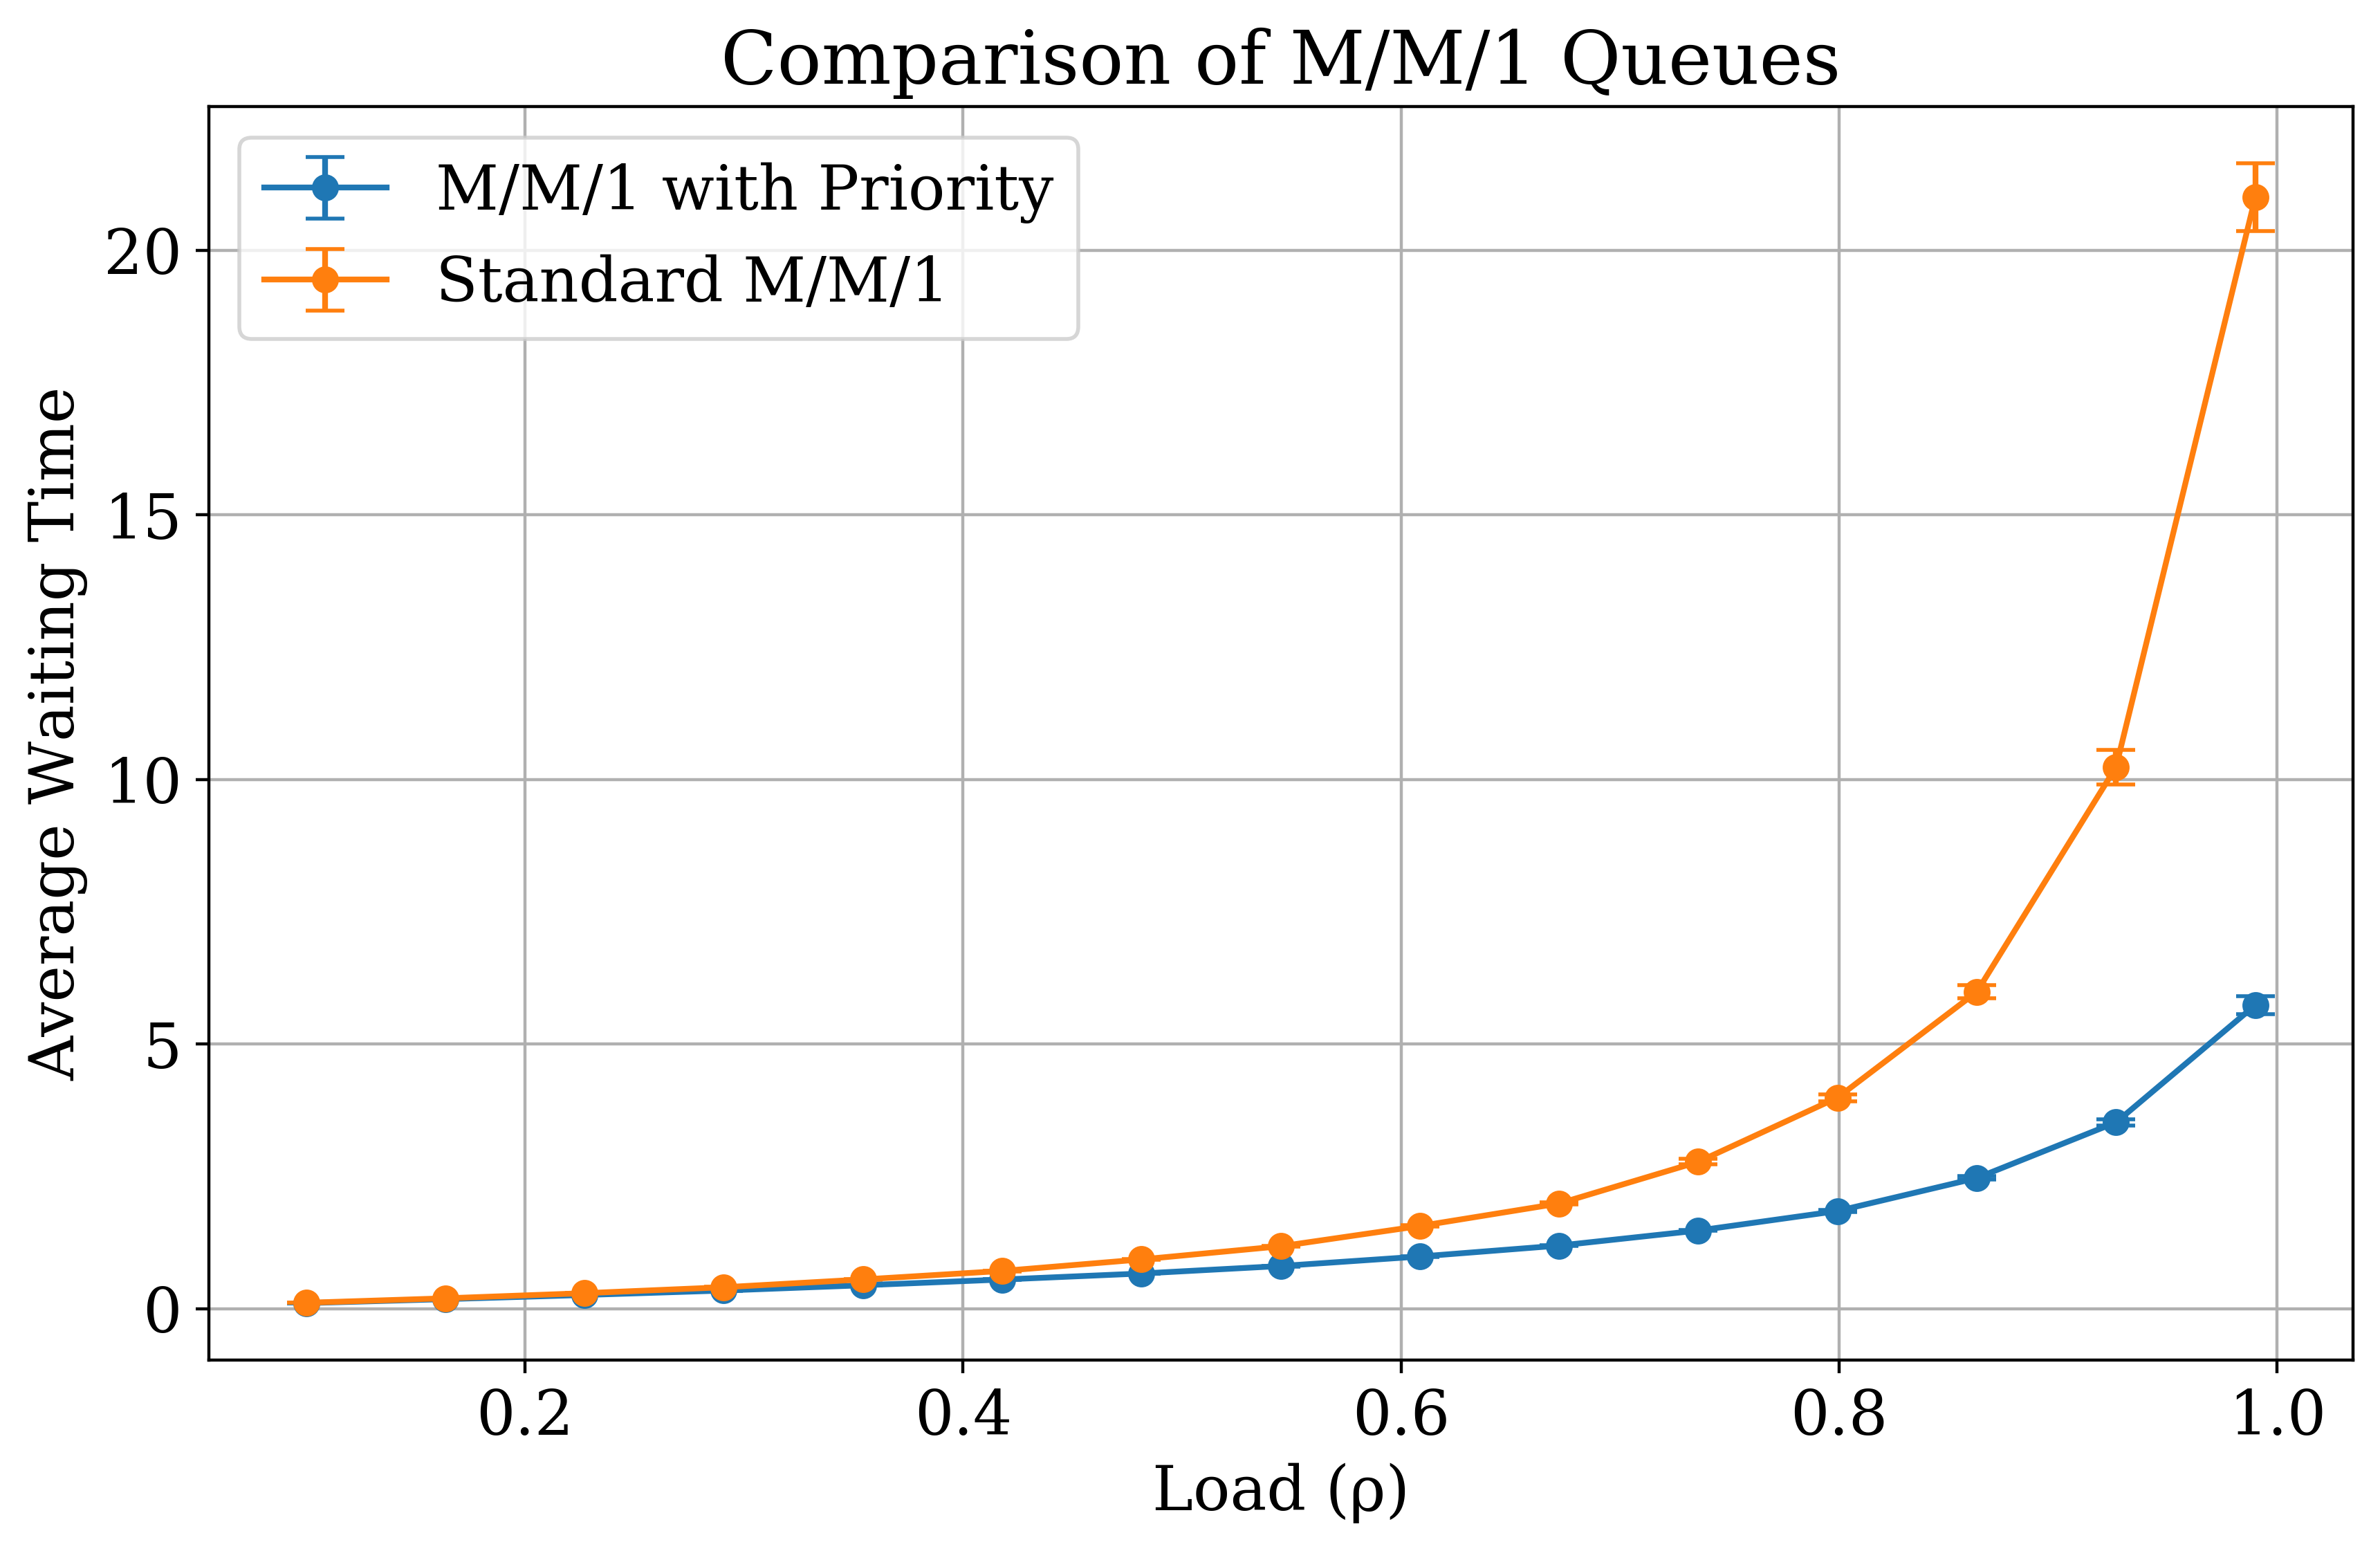

In [55]:
plt.figure(figsize=[10,6], dpi=400)
lambda_values, mm1_res, mm1_errors, avg_wait, avg_wait_errors = data_comparison

plt.errorbar(lambda_values, mm1_res, yerr=mm1_errors, label='M/M/1 with Priority', fmt='-o', capsize=5)
plt.errorbar(lambda_values, avg_wait, yerr=avg_wait_errors, label='Standard M/M/1', fmt='-o', capsize=5)

plt.xlabel('Load (ρ)')
plt.ylabel('Average Waiting Time')
plt.title('Comparison of M/M/1 Queues')
plt.grid(True)
plt.legend()
plt.savefig('MM1_prio_comparison.png', dpi=400)
plt.show()

### M/D/n

In [ ]:
SERVICE_TIME = 1

# This function defines the customer arrivals at the queue.
def mdn_arrivals(env, n, interval, counter, waiting_times, mu):
    # Generate n arrivals to the counter.
    for i in range(n):
        # Generate a 'customer' process.
        c = mdn_customer(env, f'Customer{i}', counter, waiting_times, mu)
        # Add it to the environment.
        env.process(c)
        # Calculate the time to the next arrival.
        t = random.expovariate(interval)
        # Pause the 'arrivals' process, simulating waiting time.
        yield env.timeout(t)

# This function defines the process every customer goes through.
def mdn_customer(env, name, counter, time_in_system, mu):
    # Logs the arrival time of the customer.
    arrive = env.now
    # The customer requests a counter.
    with counter.request() as req:
        # Wait for the counter to be available.
        yield req
        # Calculate the time the customer waited and append.
        wait = env.now - arrive
        time_in_system.append(wait)
        yield env.timeout(SERVICE_TIME)


# Runs the simulation N times for a certain number of servers.
def run_mdn_simulation(num_servers, N, lambda_, mu, sim_time):
    waiting_times = []
    # Run the simulation N times.
    for _ in range(N):
        # Set timeline and manage scheduling and processing of events.
        env = simpy.Environment()
        # Make the counter with a certain number of servers.
        counter = simpy.Resource(env, capacity=num_servers)
        # Start the arrival process.
        env.process(mdn_arrivals(env, sim_time, lambda_, counter, waiting_times, mu))
        # Run the simulation until events are handled or time runs out.
        env.run()
    # Calculate average waiting time.
    average_wait = np.mean(waiting_times)
    return average_wait

In [ ]:
# Parameters
lambda_ = .99  # arrival rate 
mu = 1  # service rate
sim_time = 10000 
N = 10   

# Run simulations for different numbers of servers and calculate average waiting time.
MDn_res = {}
for n in [1,2,4]:
    avg_wait = run_mdn_simulation(n, N, lambda_, mu, sim_time)
    MDn_res[n] = avg_wait
    print(f"System load: {lambda_ / (n * mu):.2f}")
    print(f'Average waiting time for M/D/{n}: {avg_wait:.2f}')

### Hyper-exponential distribution

In [ ]:
# This function defines the customer arrivals at the queue.
def hpx_arrivals(env, n, interval, counter, waiting_times, service_times):
    # Generate n arrivals to the counter.
    for i in range(n):
        # Generate a 'customer' process.
        c = hpx_customer(env, f'Customer{i}', counter, waiting_times, service_times)
        # Add it to the environment.
        env.process(c)
        # Calculate the time to the next arrival.
        t = random.expovariate(interval)
        # Pause the 'arrivals' process, simulating waiting time.
        yield env.timeout(t)

# This function defines the process every customer goes through.
def hpx_customer(env, name, counter, time_in_system, service_times):
    # Logs the arrival time of the customer.
    arrive = env.now
    # The customer requests a counter.
    with counter.request() as req:
        # Wait for the counter to be available.
        yield req
        # Calculate the time the customer waited and append.
        wait = env.now - arrive
        time_in_system.append(wait)
        # Select service time
        tis = service_times.pop()
        yield env.timeout(tis)

def hyperexp_service_times(probability, time0, time1, size):
    # Generate samples to assign to phases
    samples = np.random.uniform(size=size)
    
    # Determine which phase each sample belongs to based on the given probability
    phase = np.where(samples < probability, 0, 1)
    
    # Generate samples based on the selected phase
    times = np.where(phase == 0, np.random.exponential(scale=time0, size=size),
                       np.random.exponential(scale=time1, size=size))
    
    return list(times)

# Runs the simulation N times for a certain number of servers.
def run_hpx_simulation(num_servers, N, lambda_, hyper_exp, sim_time):
    waiting_times = []
    # Run the simulation N times.
    for _ in range(N):
        # Generate service times
        service_times = hyperexp_service_times(*hyper_exp)
        # Set timeline and manage scheduling and processing of events.
        env = simpy.Environment()
        # Make the counter with a certain number of servers.
        counter = simpy.Resource(env, capacity=num_servers)
        # Start the arrival process.
        env.process(hpx_arrivals(env, sim_time, lambda_, counter, waiting_times, service_times))
        # Run the simulation until events are handled or time runs out.
        env.run()
    # Calculate average waiting time.
    average_wait = np.mean(waiting_times)
    return average_wait

### Data generation and visualisation.



In [ ]:

def has_reached_steady_state(num_servers, lambda_, mu, total_sim_time, interval=100, threshold=0.03, min_intervals=3):
    last_avg_wait = None
    stable_intervals = 0

    for start_time in range(0, total_sim_time, interval):
        sim_time = start_time + interval
        average_wait = run_simulation(num_servers, 100, lambda_, mu, sim_time)  
        print(f"Average waiting time for M/M/{num_servers} at time {sim_time}: {average_wait:.2f}")
        if last_avg_wait is not None:
            change = abs((average_wait - last_avg_wait) / last_avg_wait)
            if change < threshold:
                stable_intervals += 1
            else:
                stable_intervals = 0

            if stable_intervals >= min_intervals:

                return sim_time # Steady state reached

        last_avg_wait = average_wait

    return False  # Steady state not reached within the total simulation time

# Seems like it takes longer for the M/M/1 queue with high load to reach steady state
steady_state_reached = has_reached_steady_state(1, 0.9, 1, 10000)
print("Steady state for M/M/1 and lambda = 0.9 reached at time:", steady_state_reached)

# Seems like a M/M/2 queue with high load reaches steady state faster than a M/M/1 queue
steady_state_reached = has_reached_steady_state(2, 1.8, 1, 10000)
print("Steady state for M/M/2 and lambda = 0.9 reached at time:", steady_state_reached)



In [ ]:
def generate_data(lambda_values):
    
    mu = 1  
    N = 100  # Number of runs for each lambda
    sim_time = 2000

    data = {}

    for n in [1, 2, 4]:
        theoretical = []
        simulated_means = []
        simulated_errors = []

        for lambda_ in lambda_values:
            load = lambda_ / (n * mu)
            if load < 1:  # Only run simulations for stable systems
                theoretical.append(calculate_waiting_time(n, lambda_, mu))

                # Collect multiple waiting times for each lambda
                simulated_times = [run_simulation(n, 1, lambda_, mu, sim_time) for _ in range(N)]
                mean_time = np.mean(simulated_times)
                error = np.std(simulated_times) / np.sqrt(N)  # Standard Error

                simulated_means.append(mean_time)
                simulated_errors.append(error)
            else:
                theoretical.append(float('inf'))
                simulated_means.append(float('inf'))
                simulated_errors.append(0)  # No error for unstable systems

        data[n] = {
            'lambda': lambda_values, 
            'theoretical': theoretical, 
            'simulated_means': simulated_means,
            'simulated_errors': simulated_errors
        }

    return data


def generate_data_load(load_values):
    
    mu = 1  
    N = 100  # Number of runs for each lambda
    sim_time = 1500

    data = {}

    for n in [1, 2, 4]:
        theoretical = []
        simulated_means = []
        simulated_errors = []

        for load in load_values:
            lambda_ = load * n * mu
            
            theoretical.append(calculate_waiting_time(n, lambda_, mu))

            # Collect multiple waiting times for each lambda
            simulated_times = [run_simulation(n, 1, lambda_, mu, sim_time) for _ in range(N)]
            mean_time = np.mean(simulated_times)
            error = np.std(simulated_times) / np.sqrt(N)  # Standard Error

            simulated_means.append(mean_time)
            simulated_errors.append(error)

        data[n] = {
            'load': load_values, 
            'theoretical': theoretical, 
            'simulated_means': simulated_means,
            'simulated_errors': simulated_errors
        }

    return data

load_values = np.linspace(0.05, 0.99, 30)
data_normal_2  = generate_data_load(load_values)

[6.100490084967014e-06, 1.4645191327417887e-05, 3.637948185239836e-05, 8.434498736316736e-05, 0.00011512105286570228, 0.00024164437196771046, 0.00030519953366166177, 0.0004458927181306211, 0.0005108929824129834, 0.0008250640875071531, 0.001048379760265858, 0.0012201996086880474, 0.0016848711592782658, 0.0022598616706174966, 0.0026713244179050353, 0.0036012946047601774, 0.004087132385969971, 0.004324876670391619, 0.007272965570683967, 0.007150937783863105, 0.010501425200027592, 0.014001829532615187, 0.015703105848228687, 0.02119132598592417, 0.04776317063209781, 0.049104998213126735, 0.060401926431202735, 0.16436030084030298, 0.25421563095024896, 0.3567496831277769]


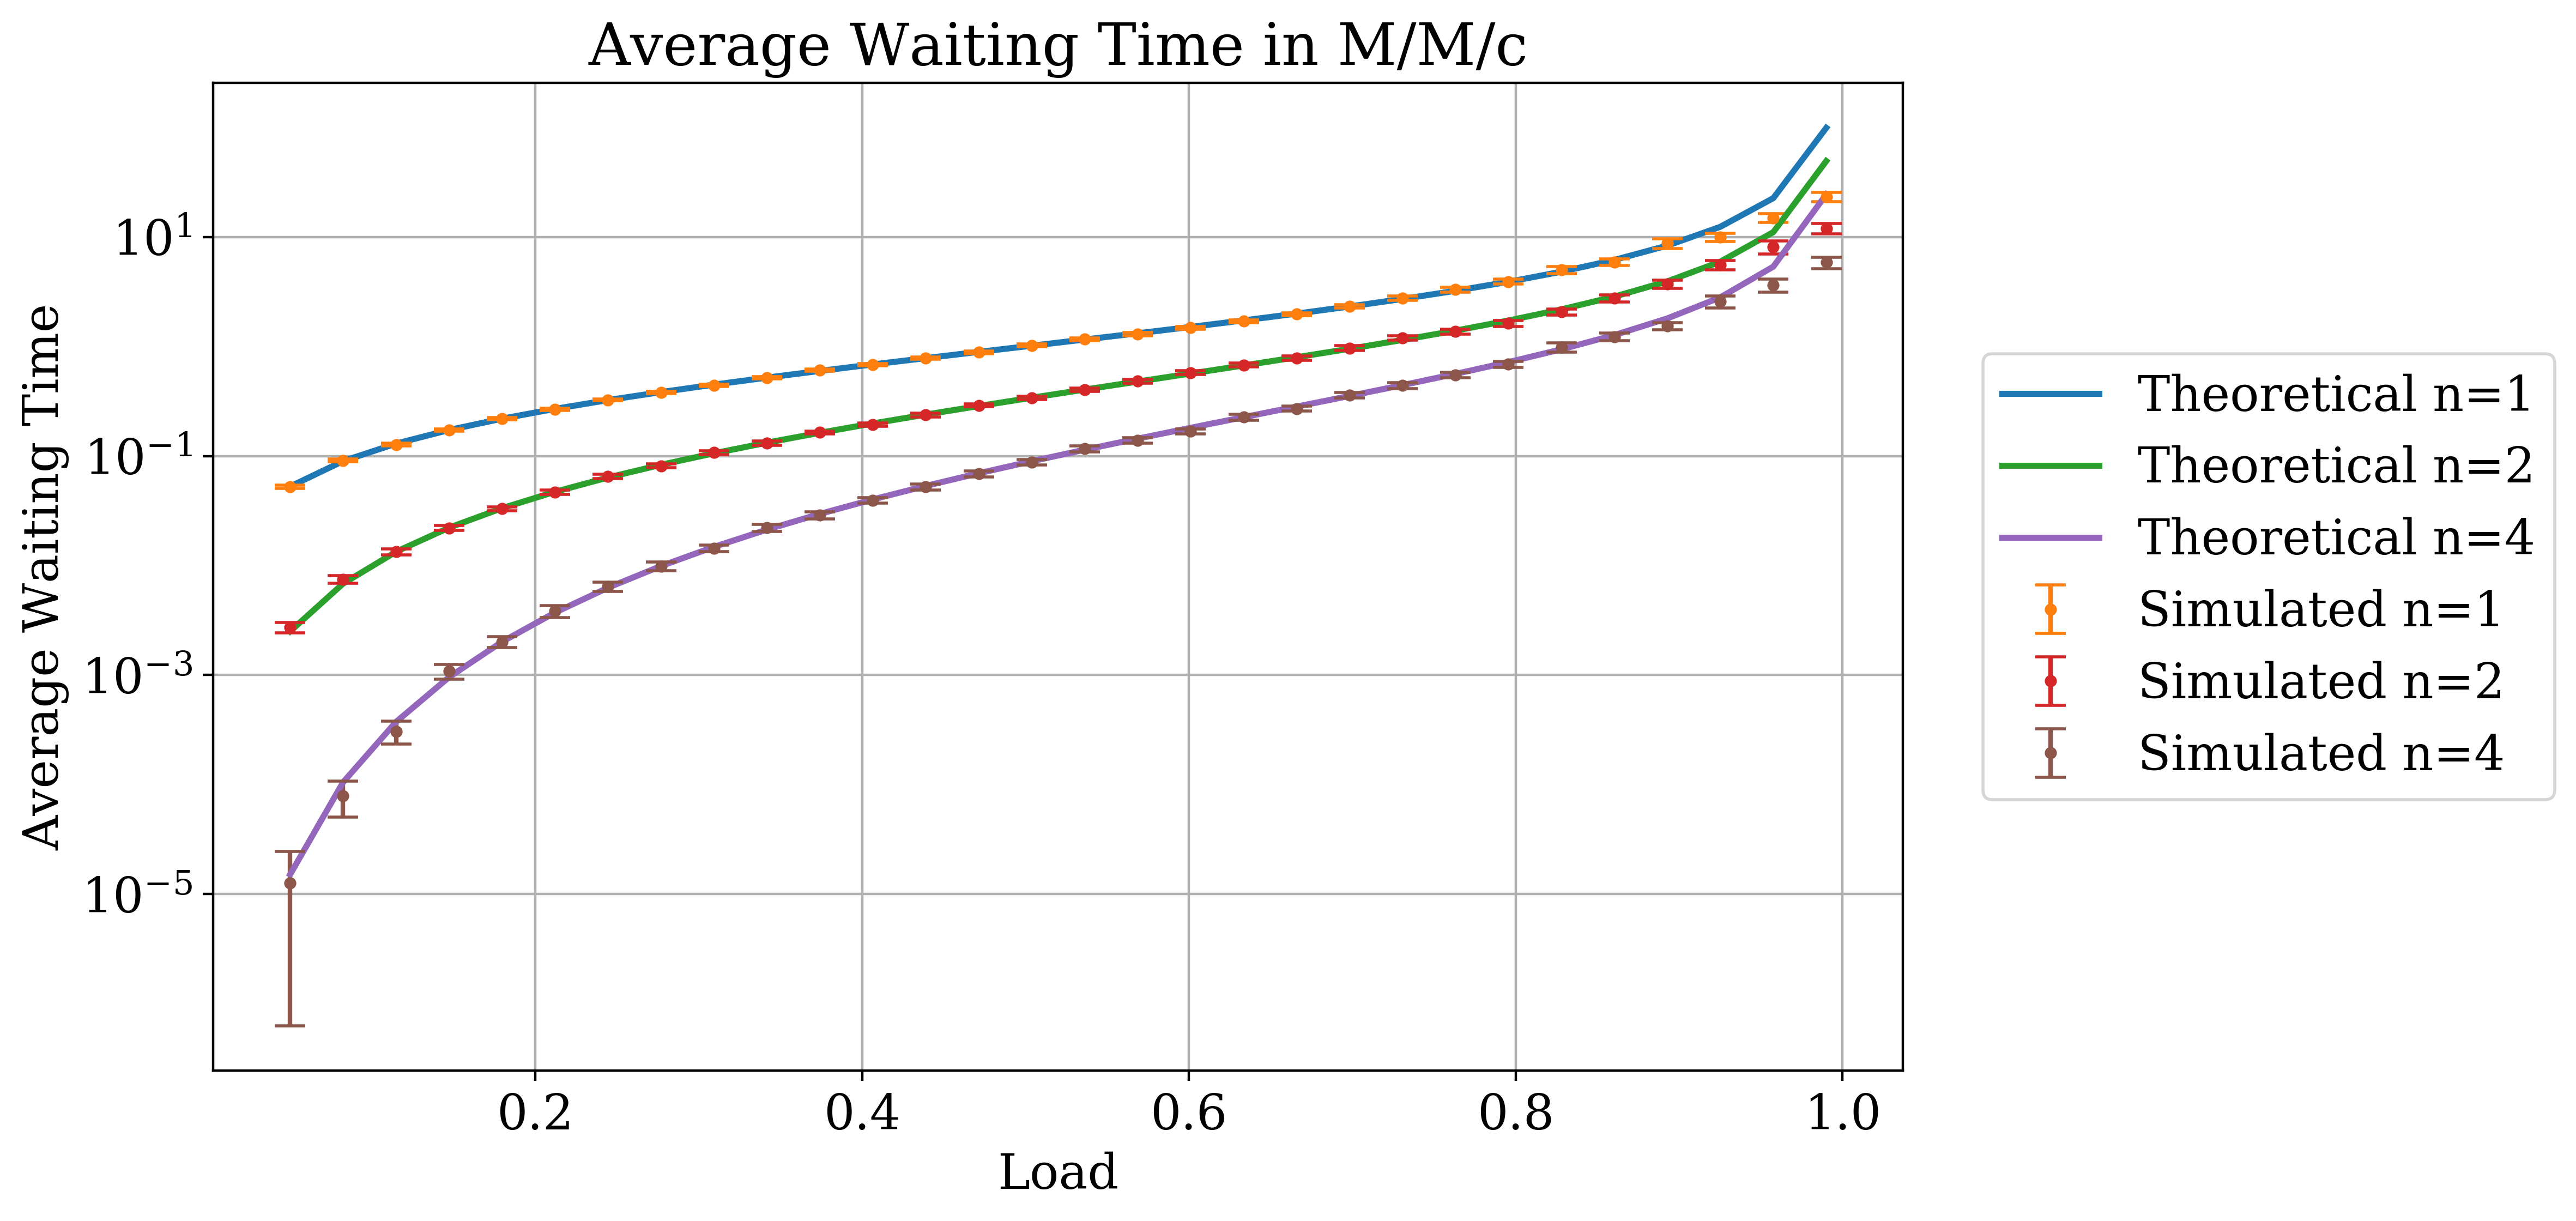

In [54]:
confidence_level = 1.96  # For a 95% confidence interval
plt.figure(figsize=[10,6],dpi=400)

for n, values in data_normal_2.items():
    if n != 6:
        # Plot theoretical values
        plt.plot(values['load'], values['theoretical'], label=f"Theoretical n={n}", linewidth=2)

        # Calculate the confidence interval
        ci = [error * confidence_level for error in values['simulated_errors']]

        # Plot simulated values with confidence intervals
        plt.errorbar(values['load'], values['simulated_means'], yerr=ci, 
                        label=f"Simulated n={n}", fmt='o', capsize=5,markersize=3)

print(data_normal_2[4]['simulated_errors'])
plt.grid(True)
plt.xlabel('Load')
plt.ylabel('Average Waiting Time')
plt.title('Average Waiting Time in M/M/c')
plt.yscale('log')
plt.legend(loc='center right', bbox_to_anchor=(1.4, 0.5))
plt.savefig('Wait_vs_Theory.png', dpi=400)
plt.show()

In [ ]:
def calculate_relative_error(standard_deviation, mean):
    if mean != 0:
        return standard_deviation / mean
    else:
        return float('inf')  # or handle as a special case

from scipy import stats

def generate_load_impact_data(num_servers, mu, num_runs, sim_time, load_levels):
    data = {}

    for n in num_servers:
        variances = []
        means = []
        print(f"Running simulations for M/M/{n}")
        for load in load_levels:
            lambda_ = load * n * mu  # Set lambda to achieve the desired load
            waiting_times = [run_simulation(n, 1, lambda_, mu, sim_time) for _ in range(num_runs)]
            means.append(np.mean(waiting_times))
            variances.append(np.std(waiting_times))

        relative_error = [calculate_relative_error(sd, mean) for sd, mean in zip(variances, means)]
        data[n] = {'load_levels': load_levels, 'variances': variances, 'relative_error': relative_error}
    
    return data

# Example usage
num_servers = [1,2,4]
mu = 1
num_runs = 100
sim_time = 1000
load_levels = np.linspace(0.1, 0.999, 100)
data_variance = generate_load_impact_data(num_servers, mu, num_runs, sim_time, load_levels)

In [ ]:
plt.figure(figsize=(12, 6))
for n, values in data_variance.items():
    # plt.plot(values['load_levels'], values['variances'], label=f'n={n}', marker='o')
    plt.plot(values['load_levels'], values['relative_error'], label=f'n={n}', marker='o')

plt.xlabel('Load (rho)')
plt.ylabel('Variability on average waiting time')
plt.title('Impact of Load on Variability in Queue Waiting Time')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
from scipy import stats


def test_runs_needed_for_significance(mu, c, sim_time, target_confidence):
    load_levels = np.linspace(0.1, 0.95, 40)  # Varying load from 0.1 to just below 1
    runs_needed = np.zeros(len(load_levels))
    i = 0
    for rho in load_levels:
        print(rho)
        lambda_ = rho * c * mu
        runs = 0
        achieved_confidence = False
        
        while not achieved_confidence and runs <= 10000:
            results = [run_simulation(c, 1, lambda_, mu, sim_time) for _ in range(20)]
            runs += 20
            mean_result, std_dev = np.mean(results), np.std(results)
            achieved_confidence = check_confidence(mean_result, std_dev, runs, target_confidence)
            
        
        runs_needed[i] = runs
        i += 1
    return load_levels, runs_needed


def check_confidence(mean, std_dev, n, target_confidence):

    # Calculate the t-score for the given confidence level and sample size
    t_score = stats.t.ppf(1 - (1 - target_confidence) / 2, df=n-1)

    # Calculate the margin of error
    margin_of_error = t_score * (std_dev / np.sqrt(n))

    # Calculate the width of the confidence interval
    confidence_interval_width = margin_of_error * 2

    # Define a threshold for what you consider 'narrow enough'
    # So we are 95% confident that the mean is within 0.1 of the sample mean
    
    threshold = 0.1 * abs(mean)

    return confidence_interval_width < threshold


# Running the test
mu = 1  # Fixed service rate
c = 1  # Number of servers (for M/M/1)
sim_time = 1000  # Simulation time for each run
target_confidence = 0.98  # Desired confidence level

runs_needed_average = np.zeros(40)
for i in range(10):
    load_levels, runs_needed = test_runs_needed_for_significance(mu, c, sim_time, target_confidence)

    runs_needed_average = runs_needed_average + runs_needed/10

In [ ]:
# Plotting the results

plt.plot(load_levels, runs_needed_average, marker='o')
plt.xlabel('Load (ρ)')
plt.ylabel('Runs')
plt.title('Load vs Runs needed for 98 confident mean is within 10 percent of the sample mean')
plt.savefig('Load_vs_Runs.png', dpi=400)
plt.show()

In [62]:
def generate_distribution_data():
    load_values = np.linspace(0.1, 0.999, 30)
    mu = 1
    N = 100
    sim_time = 2000
    hyper_exp_params = (0.75, 1.0, 5.0, sim_time)

    data = {}

    for n in [1, 2, 4]:
        mdn_results = []
        hpx_results = []
        for load in load_values:
            lambda_ = load * n * mu
            mdn_results.append(run_mdn_simulation(n, N, lambda_, mu, sim_time))
            load = lambda_ / (n * 2*mu)
            hpx_results.append(run_hpx_simulation(n, N, lambda_, hyper_exp_params, sim_time))

        data[n] = {'load': load_values, 'mdn': mdn_results, 'hpx': hpx_results}

    return data

G_mdn_hpx_data = generate_distribution_data()

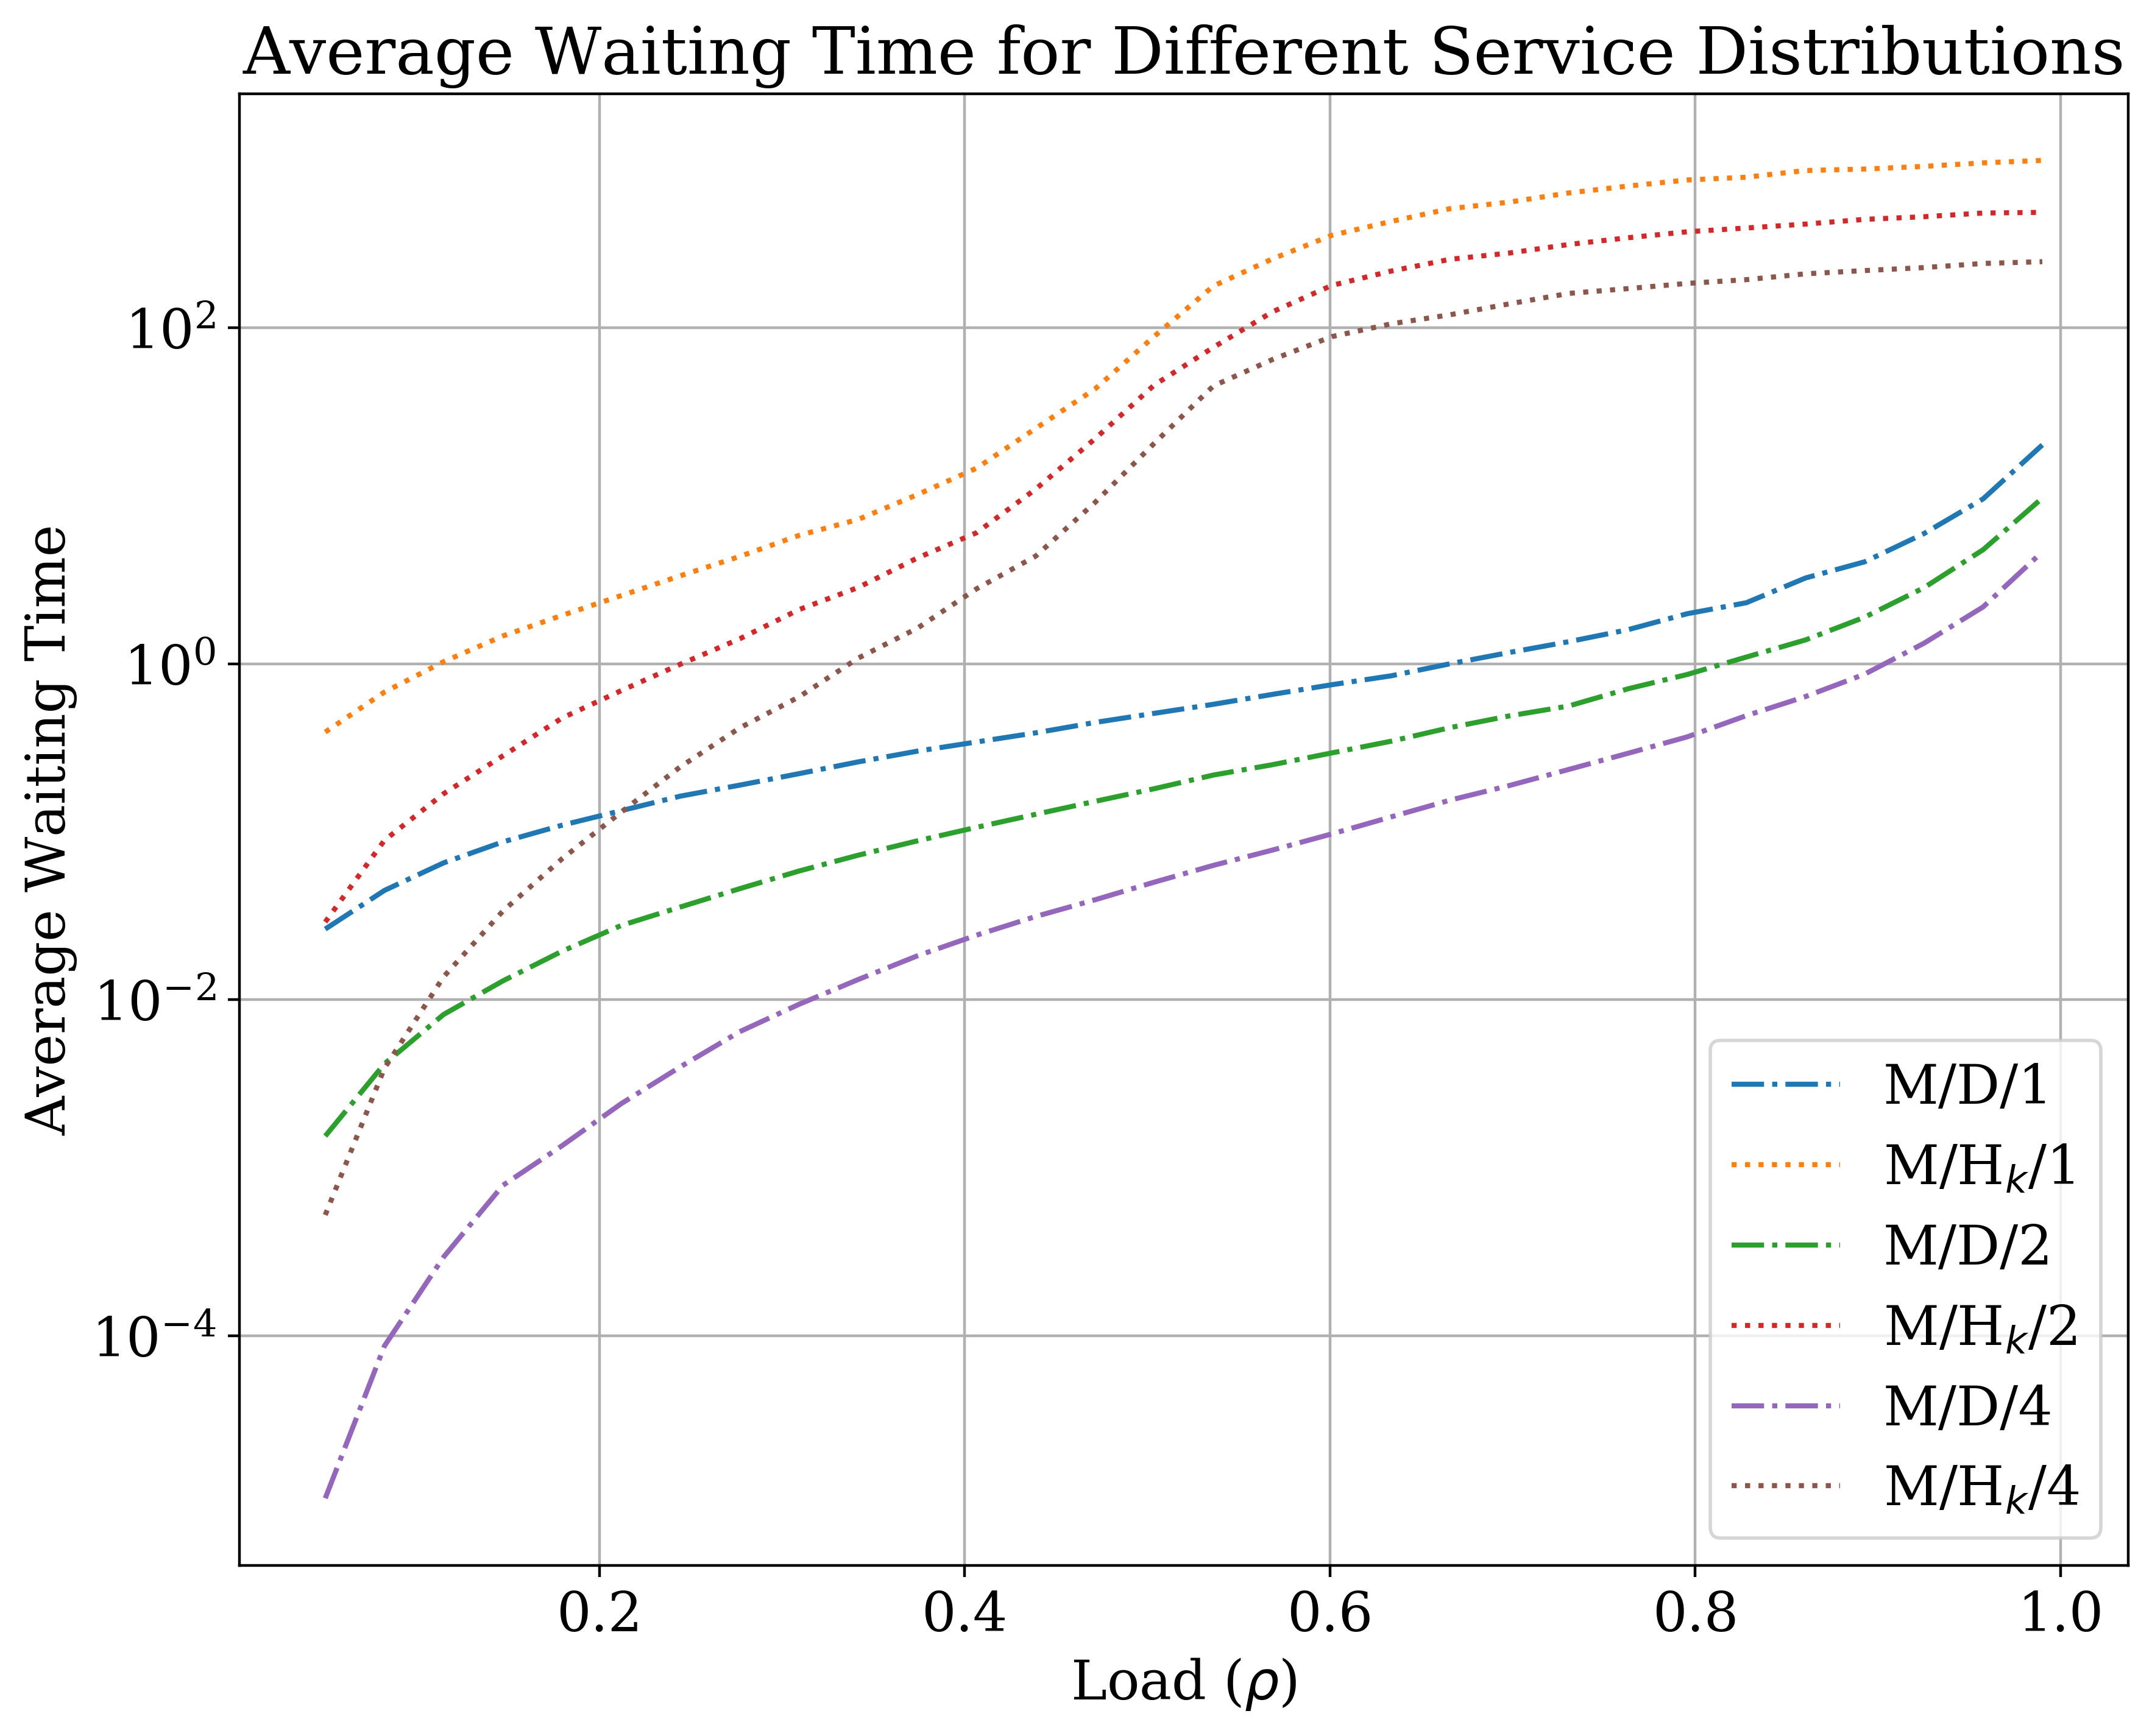

In [65]:
plt.figure(figsize=[10,8], dpi=400)
for n, values in G_mdn_hpx_data.items():
    plt.plot(values['load'], values['mdn'], label=f"M/D/{n}", linestyle='-.')
    plt.plot(values['load'], values['hpx'], label=f"M/H$_k$/{n}", linestyle=':')


plt.xlabel(r'Load ($\rho$)')
plt.grid(True)
plt.ylabel('Average Waiting Time')
plt.title('Average Waiting Time for Different Service Distributions')
plt.yscale('log')
plt.legend()
plt.show()